In [1]:
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.signal as ss
import scipy.linalg as sl

import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils as ut

In [2]:
a = np.loadtxt(os.path.join(os.getcwd(), '../Exercise5/filter-data.txt'))
print(a[0])

1.0


### Generate a pulse-sequence with a length of 32 ms that represents a voiced excitation source signal with a fundamental frequency of 100 Hz

In [3]:
def generate_pulse_train(length_ms=32, f0_hz=100, fs_hz=16000):
    train = np.zeros(ut.ms_to_idx(length_ms, fs_hz))
    train[::ut.hz_to_idx(f0_hz, fs_hz)] = 1
    
    return AudioSignal(data=train, sampling_freq_hz=fs_hz)

u = generate_pulse_train(length_ms=32, f0_hz=100, fs_hz=16000)

Successfully loaded audio signal with 1 channel!


### 2. Create an artificial speech sound s by filtering the generated excitation source u with the provided vocal tract filter coefficients a 

In [4]:
b = np.array([1])
s = ss.lfilter(b, a, u.data)

### Then, apply a Hann window w to s and u

In [5]:
w = ss.get_window('hann', ut.ms_to_idx(32, fs=16000))

s_w = w * s
u_w = w * u.data

### Plot the amplitude spectrum and the log amplitude spectrum of the vocal tract filter h (defined by the coefficients a), of the windowed excitation source u_w = w ⊗ u, as well as of the windowed filtered signal s_w = w ⊗ s

In [6]:
freqs, H = ss.freqz(b, a, len(s), whole=True, fs=16000)
S_w = np.fft.rfft(s_w)
U_w = np.fft.rfft(u_w)

In [7]:
def plot_mag_spectrum(spectrum, 
                      freq_axis=None,
                      square=False,
                      log=False,
                      figname=None):
    
    
    fig, ax = plt.subplots(1)
    ax.set_ylabel('Magnitude')
    
    mag = np.abs(spectrum)
    
    if square:
        mag = mag ** 2
    if log:
        mag = np.log(mag)
    
    l = "log"
    nl = ""
    if freq_axis is None:
        ax.plot(mag, label=f"{l if log else nl} amplitude spectrum")
    else:
        ax.set_xlabel('Frequency [Hz]')
        ax.plot(freq_axis[:len(mag)], mag, label=f"{l if log else nl} amplitude spectrum")
    
    ax.legend()
    
    if figname is not None:
        plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', figname))

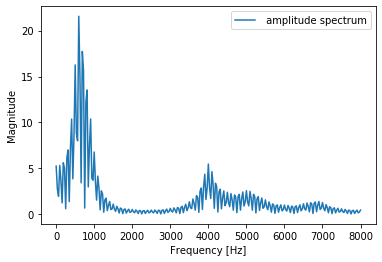

In [8]:
plot_mag_spectrum(S_w, freqs, figname='S_w_mag_db')

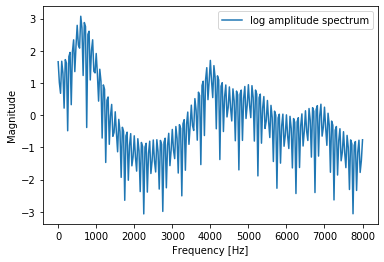

In [9]:
plot_mag_spectrum(S_w, freqs, log=True, figname='S_w_log_mag_db')

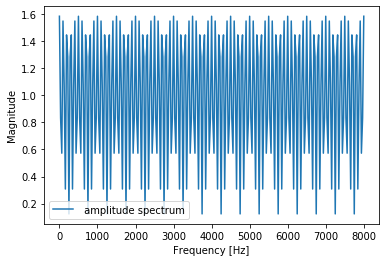

In [10]:
plot_mag_spectrum(U_w, freqs, log=False, figname='U_w_mag_db')

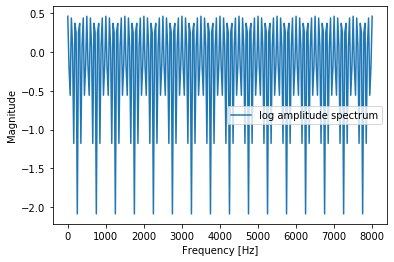

In [11]:
plot_mag_spectrum(U_w, freqs, log=True, figname='U_w_log_mag_db')

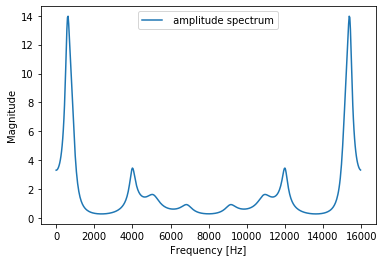

In [12]:
plot_mag_spectrum(H, freqs, log=False, figname='H_mag_db')

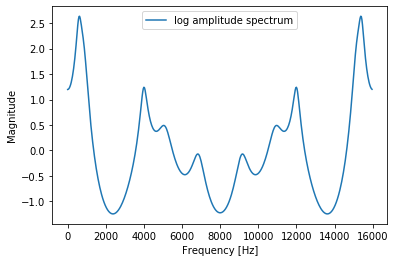

In [13]:
plot_mag_spectrum(H, freqs, log=True, figname='H_log_mag_db')

## Compute and plot:  real cepstrum of the windowed filtered signal

In [14]:
def compute_cepstrum(discrete_time_domain_signal: np.ndarray, square=True, shift=True, real=True):
    
    # 1 compute the spectrum
    spectrum = np.fft.rfft(discrete_time_domain_signal)
    
    # compute magnitude spectrum
    mag = np.abs(spectrum)
    
    # square
    if square:
        mag = mag ** 2
    
    # 2 compute the log magnitude (square) spectrum
    log_mag = np.log(mag)
    
    # 3 compute the cepstrum by applying the IDFT of the log mag spectrum
    cepstrum = np.fft.irfft(log_mag)
    
    if shift:
        cepstrum = np.fft.ifftshift(cepstrum)
    
    return cepstrum
    

In [15]:
def plot_cepstrum(cepstrum: np.ndarray,
                  figname = None,
                  draw_peak = False, 
                  shifted = True):
    
    
    fig, ax = plt.subplots(1)
    
    if shifted:
        quefrency_axis = np.arange(-cepstrum.size // 2, cepstrum.size // 2)
        ax.plot(quefrency_axis, cepstrum, label="real cepstrum")
    else:
        ax.plot(cepstrum, label="real cepstrum")
        
    ax.set_xlabel('Quefrency index [n * 1/fs]')
    
    # find f0    
    if draw_peak:
        peak = np.argmax(cepstrum[cepstrum.size // 2 + 20:]) + 20
        f0_hz = ut.ms_to_hz(ut.idx_to_ms(peak, 16000))
        ax.axvline(peak, color='r', linewidth=.5, label=f"peak at {peak} => f_0 = {f0_hz}Hz")
    
    ax.legend()
    
    if figname is not None:
        plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', figname))
    

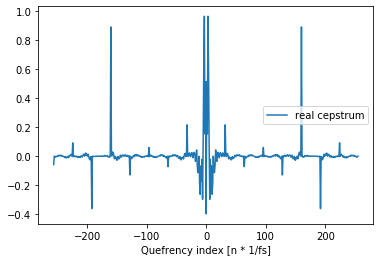

In [16]:
c_s = compute_cepstrum(s_w, shift=True)
plot_cepstrum(c_s, "r_c_s", draw_peak=False)

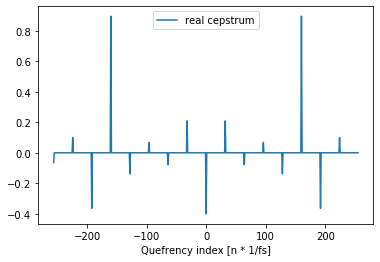

In [17]:
c_u = compute_cepstrum(u_w, shift=True)
plot_cepstrum(c_u, "r_c_u", draw_peak=False)

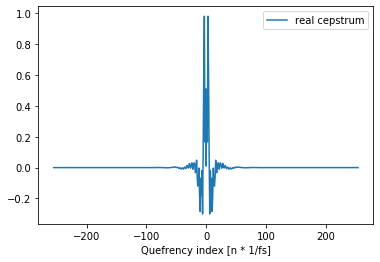

In [18]:
# 2 compute the log magnitude spectrum
freqs, H = ss.freqz(b, a, len(s), whole=True, fs=16000)
log_mag = np.log(np.abs(H[:len(H) // 2]) ** 2)

# 3 compute the cepstrum by applying the IDFT of the log mag spectrum
c_h = np.fft.ifftshift(np.fft.irfft(log_mag))
    
plot_cepstrum(c_h, "r_c_h")

# find f0

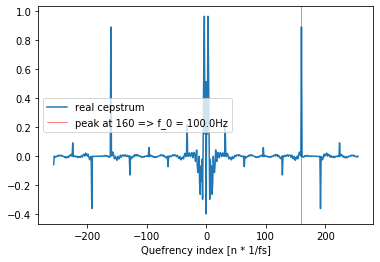

In [19]:
plot_cepstrum(c_s, "f0", draw_peak=True)

# 6.

In [20]:
def inverse_cepstral_transform(cepstrum, is_squared=False, is_shifted=False, real=True):
    def ict(cep):
        spectrum = cep

        if is_shifted:
            spectrum = np.fft.ifftshift(spectrum)

        spectrum = np.fft.rfft(spectrum)

        spectrum = np.exp(spectrum)

        if is_squared:
            spectrum = np.sqrt(spectrum)
        
        return spectrum
    
    if cepstrum.ndim == 2:
        return np.apply_along_axis(ict, 1, cepstrum)
    else: 
        return ict(cepstrum)

In [21]:
def reconstruct_filter_and_source(cepstrum, cut_off_quefrency_ms, fs_hz = 16000):
    
    # n_co (cut of freq index)
    idx = ut.ms_to_idx(cut_off_quefrency_ms, fs_hz) // 2
    # print(f"n_co = {idx * 2}")
    
    # apply liftering by cropping the ceptrum with a perfect rectangular window 
    # to extract the vocal tract filter (i.e. obtaining the cepstrally smoothed spectogram))
    H_est = np.concatenate((cepstrum[:idx], np.zeros(cepstrum.size - 2 * idx), cepstrum[-idx:]))
    H_est = inverse_cepstral_transform(H_est)
    
    # rest of the cepstrum contains infor about f0
    U_est = np.concatenate((np.zeros(idx), cepstrum[idx:-idx], np.zeros(idx)))
    U_est = inverse_cepstral_transform(U_est)
    
    return H_est, U_est

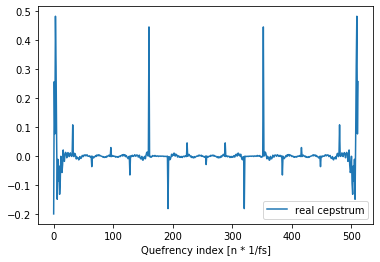

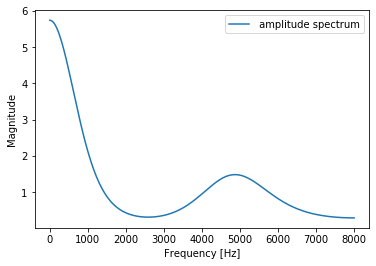

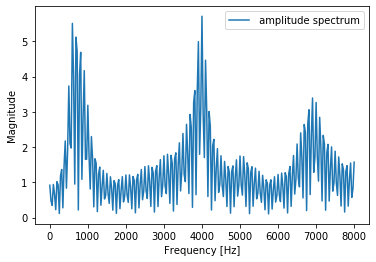

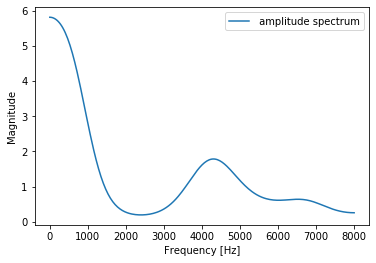

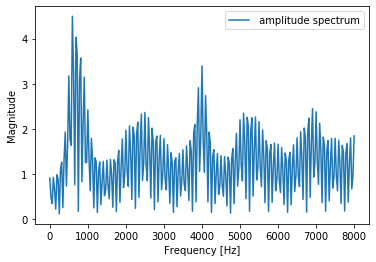

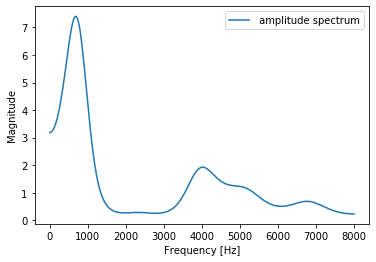

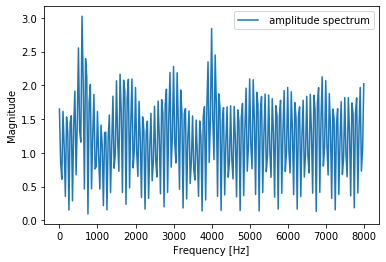

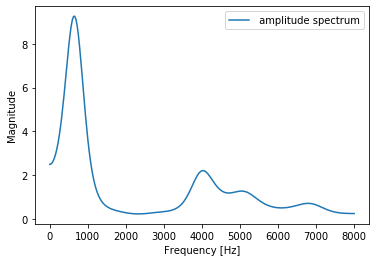

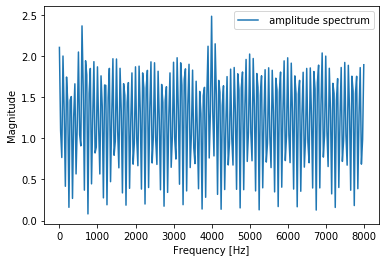

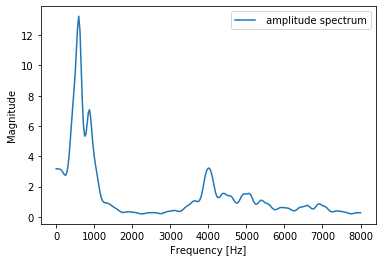

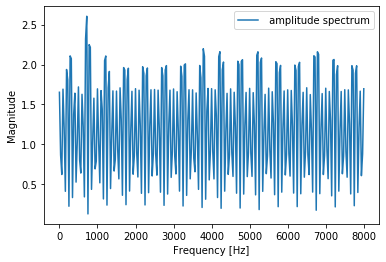

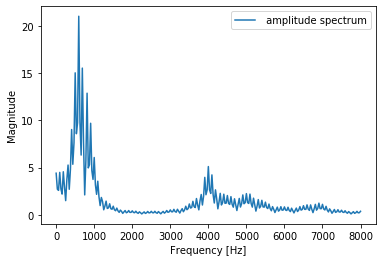

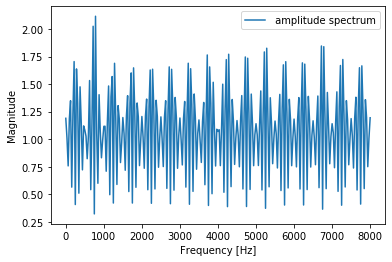

In [22]:
c_s = compute_cepstrum(s_w, shift=False, square=False)
plot_cepstrum(c_s, draw_peak=False, shifted=False)

for L in [0.5, 1., 1.5, 2., 10., 20.]:
    H_est, U_est = reconstruct_filter_and_source(c_s, cut_off_quefrency_ms=L)
    L_s = str(int(10*L))
    plot_mag_spectrum(H_est, freqs, figname=f"H_est_L_{L_s}")
    plot_mag_spectrum(U_est, freqs, figname=f"U_est_L_{L_s}")

# 7  Load the file speech1.wav. Split the signal into segments of 32 ms overlapping by 16 ms.


In [23]:
speech1 = AudioSignal(os.path.join(os.getcwd(), '../Exercise5/Audio/speech1.wav'))

/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise5/Audio/speech1.wav
Successfully loaded audio signal with 1 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise5/Audio/speech1.wav


In [24]:
stft, freq_axis_hz, frame_centers_ms = speech1.compute_stft(32, 16)
print(stft.shape)

(176, 257)


## Plot the logarithmic spectrogram as well as the real cepstrogram of the speech signal

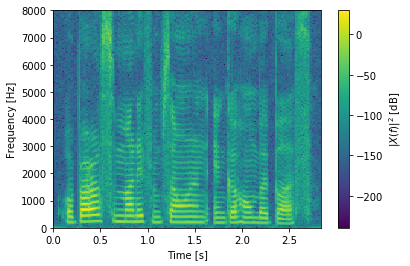

In [25]:
fig, axs = plt.subplots(1)

axs.set_ylabel('Frequency [Hz]')
axs.set_xlabel('Time [s]')

im = axs.imshow(10 * np.log(np.abs(stft.T) ** 2),
               cmap='viridis',
               origin='lower',
               extent=[0, speech1.duration_s, freq_axis_hz[0], freq_axis_hz[-1]],
               aspect='auto')

fig.colorbar(im, label=r"$|X(f)|^2$ [dB]")
plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', "log_spec_speech"))

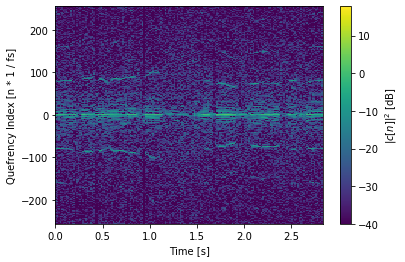

In [26]:
cepstrum, quefrency_axis, frame_centers_ms = speech1.compute_short_time_cepstrum(32, 16, shift=True)
fig, axs = plt.subplots(1)

axs.set_ylabel('Quefrency Index [n * 1 / fs]')
axs.set_xlabel('Time [s]')

im = axs.imshow(10 * np.log10(np.abs(cepstrum.T) ** 2),
               cmap='viridis',
               origin='lower',
               extent=[0, speech1.duration_s, quefrency_axis[0], quefrency_axis[-1]],
               vmin=-40,
               aspect='auto')

fig.colorbar(im, label=r"$|c[n]|^2$ [dB]");
plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', "real_cep_speech"))

In [27]:
def apply_liftering(cepstrum, cut_off_quefrency_ms, fs_hz = 16000, is_shifted=True):
    
    assert cepstrum.ndim == 2
    cep = cepstrum
    if is_shifted:
        cep = np.fft.ifftshift(cep)
    
    # n_co (cut of freq index)
    idx = ut.ms_to_idx(cut_off_quefrency_ms, fs_hz) // 2
    
    H_est = np.zeros((cep.shape[0], cep.shape[1] // 2 +1), dtype=np.complex)
    U_est = np.zeros((cep.shape[0], cep.shape[1] // 2 +1), dtype=np.complex)
    
    for i, c in enumerate(cep):
        # apply liftering by cropping the ceptrum with a perfect rectangular window 
        # to extract the vocal tract filter (i.e. obtaining the cepstrally smoothed spectogram))
        liftered = np.concatenate((c[:idx], np.zeros(c.size - 2 * idx), c[-idx:]))
        H_est[i] = inverse_cepstral_transform(liftered)
        
        
        # apply liftering by cropping the ceptrum with a perfect rectangular window 
        # to extract the vocal tract filter (i.e. obtaining the cepstrally smoothed spectogram))
        liftered = np.concatenate((np.zeros(idx), c[idx:-idx], np.zeros(idx)))
        U_est[i] = inverse_cepstral_transform(liftered)
        
        
    
    return H_est, U_est

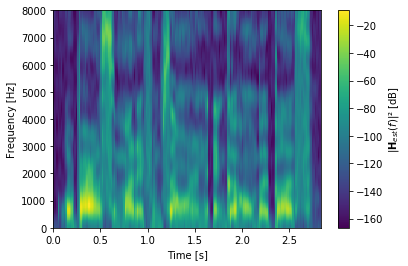

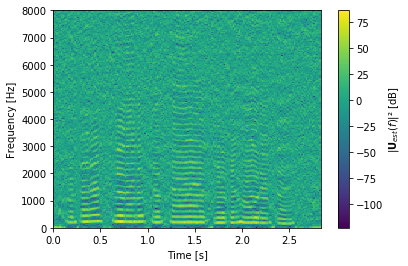

In [28]:
H_est, U_est = apply_liftering(cepstrum, 2.0)
fig, axs = plt.subplots(1)

axs.set_ylabel('Frequency [Hz]')
axs.set_xlabel('Time [s]')

im = axs.imshow(10 * np.log(np.abs(H_est.T) ** 2),
               cmap='viridis',
               origin='lower',
               extent=[0, speech1.duration_s, freq_axis_hz[0], freq_axis_hz[-1]],
               aspect='auto')

fig.colorbar(im, label=r"$|\mathbf{H}_{est}(f)|²$ [dB]")
plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', "H_est_speech"))


fig, axs = plt.subplots(1)

axs.set_ylabel('Frequency [Hz]')
axs.set_xlabel('Time [s]')

im = axs.imshow(10 * np.log(np.abs(U_est.T) ** 2),
               cmap='viridis',
               origin='lower',
               extent=[0, speech1.duration_s, freq_axis_hz[0], freq_axis_hz[-1]],
               aspect='auto')

fig.colorbar(im, label=r"$|\mathbf{U}_{est}(f)|²$ [dB]")
plt.savefig(os.path.join(os.getcwd(), '../Exercise5', 'gfx', "U_est_speech"))

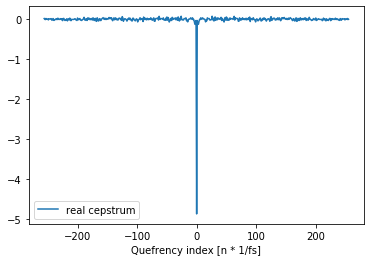

In [29]:
plot_cepstrum(cepstrum[150])